# 版本控制

In [1]:
train_batch_size=256
val_batch_size=16
folder_name="./weight_sign/"
version_name="r50_sign"
train_step=10
train_gama=0.9

data_set="fusion"

save_gpu=True

# import

In [2]:
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models.resnet import Bottleneck
import numpy as np
from itertools import product
from math import sqrt
from typing import List
from collections import defaultdict
from PIL import Image

import torch.backends.cudnn as cudnn

import matplotlib.pyplot as plt
from PIL import Image
import cv2
import os
import random
%matplotlib inline
import time
from PIL import Image
from torchvision.transforms import ToTensor,ToPILImage
from torchvision.transforms import Resize
from torchvision import transforms
import torch.optim as optim
# from apex.contrib.optimizers import FP16_Optimizer
# from apex.fp16_utils import network_to_half
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
from torch.utils.data import DataLoader,Dataset
from tqdm import tqdm
from IPython.display import clear_output
def clear():
    clear_output(wait=True)

# 准备数据

## dataset

In [3]:
train_txt_path="D://WIDC//yolo//task_dis//dataset_sign//train_sign.txt"
val_txt_path="D://WIDC//yolo//task_dis//dataset_sign//val_sign.txt"

f1=open(train_txt_path)
train_dis_list = f1.readlines()

f2=open(val_txt_path)
val_dis_list = f2.readlines()


tt=train_dis_list[0].split()
print(tt)
print(len(train_dis_list))

tt=np.array(tt)
tt=tt.astype(np.float32)
tt=torch.from_numpy(tt).cuda()
print(tt)

['0.5429166666666667', '0.4855555555555556', '0.009166666666666667', '0.05555555555555555', '0.6310666666666667']
6061
tensor([0.5429, 0.4856, 0.0092, 0.0556, 0.6311], device='cuda:0')


In [4]:
class qmdataset(Dataset): #继承Dataset
    def __init__(self, dis_list, transform=None): #__init__是初始化该类的一些基础参数
        self.dis_list = dis_list
        self.transform=transform
    
    def __len__(self):#返回整个数据集的大小
        return len(self.dis_list)
    
    def __getitem__(self,index):#根据索引index返回dataset[index]
        tt=self.dis_list[index].split()
        tt=np.array(tt)
        tt=tt.astype(np.float32)
        tt=torch.from_numpy(tt).cuda()
        xyxy=tt[:-1]
        dis=tt[-1]
        
        dis=dis.unsqueeze(-1)   
        
        return xyxy, dis #返回该样本

In [5]:
train_dataset = qmdataset(train_dis_list,transform=None)#初始化类，设置数据集所在路径以及变换
val_dataset = qmdataset(val_dis_list,transform=None)#初始化类，设置数据集所在路径以及变换

print(train_dataset)
a=train_dataset[1]
print(a[0])
print(a[1])
print(a[0].shape,a[1].shape)



tensor([0.5596, 0.4861, 0.0108, 0.0633], device='cuda:0')
tensor([0.5389], device='cuda:0')
torch.Size([4]) torch.Size([1])


## dataloader

In [6]:
train_dataloader = DataLoader(train_dataset,batch_size=train_batch_size,shuffle=True)#使用DataLoader加载数据
val_dataloader = DataLoader(val_dataset,batch_size=val_batch_size,shuffle=True)#使用DataLoader加载数据

# 查看dataloader

In [7]:
num=1
flag=0

t_inputs=0
t_labels=0
for a,b in enumerate(train_dataloader):
    print(a)
    print(b[0].shape)
    print(b[1].shape)
    # print(b[1])
    t_inputs=b[0]
    t_labels=b[1]
    flag=flag+1
    if(flag==num):
        break
print(len(train_dataloader))

for a,b in train_dataloader:
    tb_start=time.time()
    # get the inputs
    #inputs [32x4]
    #labels [32x1]
    inputs, labels = b[0],b[1]
    print(a.shape)
    print(b.shape)
    break

0
torch.Size([256, 4])
torch.Size([256, 1])
24
torch.Size([256, 4])
torch.Size([256, 1])


# 模型

In [8]:
class disnet(nn.Module):
    def __init__(self):
        super(disnet,self).__init__()
        self.backbone=nn.Sequential(
            nn.Linear(4,2048),
            nn.ReLU(),
            nn.Linear(2048,256),
            nn.ReLU(),
            nn.Linear(256,1),
        )
    def forward(self, x):
        x=self.backbone(x)
        return x
model=disnet().cuda()

### (训练时请不要运行,显存不够）

In [9]:
criterion = nn.MSELoss()
print("t_inputs.shape",t_inputs.shape,t_inputs[0])
t_outputs=model(t_inputs)
print("t_outputs.shape",t_outputs.shape,t_outputs[0])
print("t_labels.shape",t_labels.shape,t_labels[0])
loss=criterion(t_outputs,t_labels)

print(loss.shape)
print(loss)

t_inputs.shape torch.Size([256, 4]) tensor([0.7883, 0.4644, 0.0783, 0.3733], device='cuda:0')
t_outputs.shape torch.Size([256, 1]) tensor([0.0577], device='cuda:0', grad_fn=<SelectBackward>)
t_labels.shape torch.Size([256, 1]) tensor([0.0977], device='cuda:0')
torch.Size([])
tensor(0.1224, device='cuda:0', grad_fn=<MseLossBackward>)


# 开始训练

## 参数

In [10]:
# 平方差损失函数
criterion = nn.MSELoss()
#
optimizer = optim.SGD(model.parameters(), lr = 0.01, weight_decay=5e-4, momentum=0.9, nesterov=True)
#
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.2)


## 损失记录

In [11]:
train_epoch_loss=[]
# train_epoch_acc=[]
val_epoch_loss=[]
#val_epoch_acc=[]

last_val_loss=-1
last_val_loss_name=-1
# last_val_acc=-1
# last_val_acc_name=-1

## 训练函数

In [12]:
def train_model(train_dataloader, val_dataloader,mycriterion, myoptimizer,myscheduler,my_num_epochs=50):
    global train_epoch_loss,train_epoch_acc,val_epoch_loss,val_epoch_acc,last_val_loss,last_val_loss_name
    since_time = time.time()

    for epoch_i in range(0,my_num_epochs):
        
        epoch_start_time=time.time()
        # Each epoch has a training and validation phase
        # myscheduler.step()
        ############################################################################train
        ############################################################################train
        ############################################################################train
        # Set model to training mode
        model.train(True)  
        running_loss = 0.0
        # Iterate over data.
        pbar1 = tqdm(total=len(train_dataloader),desc="epoch:"+str(epoch_i)+':train',leave=False,ncols=130,position=0)
        for a,b in train_dataloader:
            tb_start=time.time()
            # get the inputs
            #inputs [32x4]
            #labels [32x1]
            inputs, labels = a,b
            # print("train inputs.shape:",inputs.shape,inputs[0])
            # print("train labels.shape:",labels.shape,labels[0])
            # now_batch_size, _ = inputs.shape
            # print("now_batch_size:",now_batch_size)
#             if now_batch_size < train_batch_size:  # skip the last batch
#                 print('continue')
#                 continue
            inputs = Variable(inputs.cuda().detach())
            labels = Variable(labels.cuda().detach())
            # zero the parameter gradients
            myoptimizer.zero_grad()

            # forward
            outputs = model(inputs)
            # print("outputs.shape",outputs.shape,outputs[0])
            loss = mycriterion(outputs, labels)
            # print("train loss",loss)
            # print("*"*100)
            # statistics
            running_loss += loss.item()
            #running_corrects_num += float(torch.sum(preds == labels.data))
            # backward + optimize only if in training phase
            loss.backward()
            myoptimizer.step()
            
            tb_end=time.time()
            tmp_lr=myoptimizer.state_dict()['param_groups'][0]['lr']
            pbar1.set_postfix(b_t=tb_end-tb_start,ep_t=tb_end-epoch_start_time,lr=tmp_lr)
            pbar1.update(1)
        pbar1.close()
        epoch_train_end_time=time.time()
            
        myscheduler.step()
        ##############
        train_loss=running_loss
        train_epoch_loss.append(train_loss)
        print("train_loss",train_loss)
        ############################################################################val
        ############################################################################val
        ############################################################################val
        # Set model to training mode
        model.train(False)  
        running_loss = 0.0
        #running_corrects_num = 0.0
        # Iterate over data.
        pbar2 = tqdm(total=len(val_dataloader),desc="epoch:"+str(epoch_i)+':val',leave=False,ncols=130,position=0)
        for a,b in val_dataloader:
            # get the inputs
            tb_start=time.time()
            inputs, labels = a,b
#             now_batch_size, four = inputs.shape
#             if now_batch_size < val_batch_size:  # skip the last batch
#                  print('continue')
#                 continue
            inputs = Variable(inputs.cuda().detach())
            labels = Variable(labels.cuda().detach())
            # print(inputs.shape)
            # print(labels.shape)
            
            # zero the parameter gradients
            myoptimizer.zero_grad()
            
            with torch.no_grad():
                outputs = model(inputs)

            # forward
            outputs = model(inputs)

            #_, preds = torch.max(outputs.data, 1)
            # print(outputs.shape)
            # print(preds.shape)
            loss = mycriterion(outputs, labels)


            # statistics
            running_loss += loss.item()
            #running_corrects_num += float(torch.sum(preds == labels.data))
            
            tb_end=time.time()
            pbar2.set_postfix(b_t=tb_end-tb_start,e_t=tb_end-epoch_train_end_time)
            pbar2.update(1)
        pbar2.close()
        ##############
        #val_loss
        val_loss=running_loss
        val_epoch_loss.append(val_loss)
        ######################################################绘制acc图片
        ######################################################绘制acc图片
        ######################################################绘制acc图片
        clear()
        print("one epoch minutes:",(time.time()-epoch_start_time)/60)
        print("epoch i=",epoch_i)
        print('train_loss:',train_loss)
        print('val_loss:',val_loss)
        fig,axes=plt.subplots(1,2)
        plt.rcParams['figure.figsize'] = (15, 5) # 单位是inches
        axes[0].set_title('train_loss')
        axes[0].plot(train_epoch_loss,marker='o')
        axes[1].set_title('val_loss')
        axes[1].plot(val_epoch_loss,marker='o')
        plt.show()
        ######################################################保存acc数据
        train_log=[]
        train_log.append(train_epoch_loss)
        train_log.append(val_epoch_loss)
        np.save(folder_name+version_name+".npy",train_log)
    print("total minutes:",(time.time()-since_time)/60)


## 开始训练

one epoch minutes: 0.01058576504389445
epoch i= 159
train_loss: 0.009685525699751452
val_loss: 0.01320124018820934


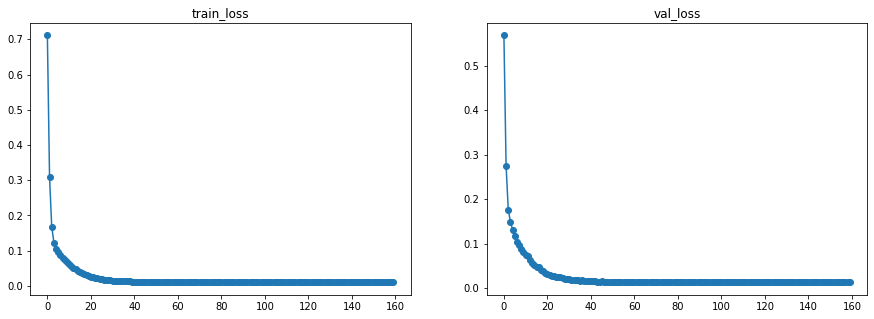

total minutes: 1.9840210278828938
./weight_sign/r50_sign.pth


In [13]:
train_model(train_dataloader,val_dataloader,criterion,optimizer,exp_lr_scheduler,160)

save_name=folder_name+version_name+".pth"
print(save_name)
torch.save(model,save_name)

In [14]:
# train_model(train_dataloader,val_dataloader,criterion,optimizer,exp_lr_scheduler,80)

# save_name=folder_name+version_name+".pth"
# print(save_name)
# torch.save(model,save_name)